In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
import keras.utils as image
from ast import literal_eval
from keras.utils import pad_sequences
from tqdm import tqdm
import glob,os,json
import requests
import matplotlib.pyplot as plt
import urllib.request, io
from PIL import Image,ImageDraw
from io import BytesIO
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
train=pd.read_csv('Data/multilabel_classification/train.csv')
train

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...,...
5945,701715fe-b278-4310-ac1d-cca8ddacc830,[283.0]
5946,45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a,[283.0]
5947,676b982a-deeb-46ee-b47d-8a97a1b0c76c,[283.0]
5948,7e09c9a9-72e5-4374-9ed6-dae1ee2ea33d,[286.0]


In [6]:
df_categ=pd.read_csv('Data/category_key.csv')
df_categ

,id,name,supercat
0,1,Actiniaria,Anemone
1,2,Actinernus,Anemone
2,3,Actiniidae,Anemone
3,4,Actinoscyphia,Anemone
4,5,Bolocera,Anemone
...,...,...,...
285,286,Polychaeta,Worm
286,287,Polynoidae,Worm
287,288,Sabellidae,Worm
288,289,Serpulidae,Worm


In [7]:
len(set(df_categ['name']))

290

In [8]:
path = r'Data/images/' # use your path
pred_files = glob.glob(os.path.join(path, "*.png"))
ls=[]
for file in pred_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    ls.append(filename)
    df_name=pd.DataFrame({'id':ls})

In [9]:
df_train=train[train['id'].isin(df_name['id'])]
df_train

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...,...
133,53b0e247-00d0-4f5d-9928-357cff757237,"[1.0, 52.0, 211.0]"
134,dba29b41-55eb-4ce4-b5a7-5f82c0c1ed6a,"[1.0, 52.0, 88.0, 146.0]"
135,7fa334d6-b271-49e1-b2d3-bc9365888fff,"[1.0, 61.0, 107.0]"
136,75e8e2a8-cee9-498d-883b-ef002f56bdad,"[1.0, 8.0, 243.0]"


In [10]:
# # apply function to each element of DataFrame
# df_train['categories'] = df_train['categories'].str.strip('[]')
# df_train['categories'] = df_train['categories'].str.replace(',','')

In [11]:
f = open('Data/object_detection/train.json')
dict_train = json.load(f)

In [12]:
df_train_images = pd.json_normalize(dict_train['images'])
# we can remove "license" as this is always 0
df_train_images.drop(['license'], axis=1, inplace=True)
# show preview
df_train_images.head(5)

,id,width,height,file_name,flickr_url,coco_url,date_captured
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38
2,3,720,368,4a7f2199-772d-486d-b8e2-b651246316b5.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:44
3,4,720,368,3bddedf6-4ff8-4e81-876a-564d2b03b364.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 17:54:14
4,5,720,369,3f735021-f5de-4168-b139-74bf2859d12a.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-28 19:00:00


In [13]:
len(df_train_images)

5950

In [14]:
def drop_suffix(i_str):
    length = len(i_str)
    return i_str[0:(length-4)]

# add filename-based id to image table in order to be able to join with df_train
df_train_images['id_file'] = df_train_images.file_name.apply(drop_suffix)
df_train_images.head(2)

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,720,368,3b6f01ae-5bde-434d-9b06-79b269421ed6.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:34,3b6f01ae-5bde-434d-9b06-79b269421ed6
1,2,720,368,dce21f7c-20e5-482b-bd90-c038f8464c03.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-08-17 17:50:38,dce21f7c-20e5-482b-bd90-c038f8464c03


In [15]:
df_train=train[train['id'].isin(df_train_images['id_file'])]
df_train

,id,categories
0,3b6f01ae-5bde-434d-9b06-79b269421ed6,[1.0]
1,dce21f7c-20e5-482b-bd90-c038f8464c03,[1.0]
2,4a7f2199-772d-486d-b8e2-b651246316b5,[1.0]
3,3bddedf6-4ff8-4e81-876a-564d2b03b364,"[1.0, 9.0, 11.0, 88.0]"
4,3f735021-f5de-4168-b139-74bf2859d12a,"[1.0, 37.0, 51.0, 119.0]"
...,...,...
5945,701715fe-b278-4310-ac1d-cca8ddacc830,[283.0]
5946,45e73fdd-d8a2-4ee1-abc7-3e34d2dfa82a,[283.0]
5947,676b982a-deeb-46ee-b47d-8a97a1b0c76c,[283.0]
5948,7e09c9a9-72e5-4374-9ed6-dae1ee2ea33d,[286.0]


In [2]:
# import keras.utils as image

# train_image = []
# count=0
# for link in df_train_images['flickr_url']:
#     response = requests.get(link)
#     img = Image.open(BytesIO(response.content))
#     img = img.resize((300, 300))
#     img = image.img_to_array(img)
#     img = img / 255.0
#     train_image.append(img)
#     count=count+1
#     print(count)

# X = np.array(train_image)

In [3]:
# for img in train_image:
#     print(img.shape)

In [16]:
train_image=np.load('X_data.npy')

In [17]:
import cv2
train_image_resized = []
for img in train_image:
    if img.shape == (300, 300, 4):
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    img = cv2.resize(img, (300, 300))
    train_image_resized.append(img)

X = np.array(train_image_resized)

In [57]:
#flat_train = train_image.reshape(-1, train_image.shape[-1])

# np.save('X_data.npy', X)

In [59]:
# # load array
# dt = np.load('X_data.npy')
# dt

In [33]:
classes=df_categ['name']
classes

0         Actiniaria
1         Actinernus
2         Actiniidae
3      Actinoscyphia
4           Bolocera
           ...      
285       Polychaeta
286       Polynoidae
287       Sabellidae
288       Serpulidae
289     Terebellidae
Name: name, Length: 290, dtype: object

In [34]:
y=df_train['categories'][:1003]
y

0                          [1.0]
1                          [1.0]
2                          [1.0]
3         [1.0, 9.0, 11.0, 88.0]
4       [1.0, 37.0, 51.0, 119.0]
                  ...           
998                       [37.0]
999                       [37.0]
1000                      [37.0]
1001                      [37.0]
1002                      [37.0]
Name: categories, Length: 1003, dtype: object

In [35]:
y = y.apply(literal_eval)
y

0                          [1.0]
1                          [1.0]
2                          [1.0]
3         [1.0, 9.0, 11.0, 88.0]
4       [1.0, 37.0, 51.0, 119.0]
                  ...           
998                       [37.0]
999                       [37.0]
1000                      [37.0]
1001                      [37.0]
1002                      [37.0]
Name: categories, Length: 1003, dtype: object

In [36]:
max_length = max(len(x) for x in y)
max_length

padded_sequences = pad_sequences(y, maxlen=max_length, padding='post', value=0.0)
padded_sequences

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [37,  0,  0, ...,  0,  0,  0],
       [37,  0,  0, ...,  0,  0,  0],
       [37,  0,  0, ...,  0,  0,  0]])

In [37]:
y = np.array(padded_sequences)
y

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [37,  0,  0, ...,  0,  0,  0],
       [37,  0,  0, ...,  0,  0,  0],
       [37,  0,  0, ...,  0,  0,  0]])

In [38]:
y = y.reshape(-1,)
y

array([1, 0, 0, ..., 0, 0, 0])

In [39]:
len(y)

10030

In [40]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y[:1003],test_size=0.15)

In [48]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(260, activation='softmax')
])

In [49]:
cnn.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [50]:
cnn.fit(X_train, y_train, epochs=5)

Epoch 1/5
27/27 [==============================] - 81s 3s/step - loss: 2.6100 - accuracy: 0.6538
Epoch 2/5
27/27 [==============================] - 71s 3s/step - loss: 1.8238 - accuracy: 0.6761
Epoch 3/5
27/27 [==============================] - 73s 3s/step - loss: 1.6525 - accuracy: 0.6772
Epoch 4/5
27/27 [==============================] - 71s 3s/step - loss: 1.5932 - accuracy: 0.6784
Epoch 5/5
27/27 [==============================] - 70s 3s/step - loss: 1.5223 - accuracy: 0.6819


In [51]:
cnn.evaluate(X_test,y_test)

5/5 [==============================] - 9s 658ms/step - loss: 1.5465 - accuracy: 0.6689


[1.546520709991455, 0.6688741445541382]

In [52]:
y_pred = cnn.predict(X_test)
y_pred[:5]

5/5 [==============================] - 3s 640ms/step


array([[6.2893027e-01, 1.1776523e-01, 1.9342941e-05, ..., 7.4650316e-06,
        2.4982353e-05, 1.2438842e-05],
       [7.9009205e-01, 8.2862630e-02, 2.2067888e-06, ..., 3.5302492e-07,
        4.9383339e-06, 8.5031672e-07],
       [7.0935416e-01, 1.0114742e-01, 8.4113253e-06, ..., 2.8796812e-06,
        1.4953966e-05, 5.5215446e-06],
       [7.2544414e-01, 1.0556941e-01, 5.3417962e-06, ..., 1.4604523e-06,
        8.6893497e-06, 3.5234227e-06],
       [7.8706640e-01, 1.3335770e-01, 4.1273611e-07, ..., 6.2932855e-08,
        5.3205974e-07, 2.2049782e-07]], dtype=float32)

In [53]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[0, 0, 0, 0, 0]

In [54]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

Actual Value


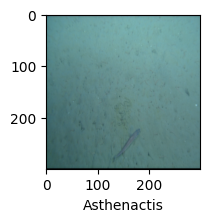

In [60]:
print('Actual Value')
plot_sample(X_test, y_test,50)

In [61]:
print('Predicted Value-')
classes[y_classes[50]]

Predicted Value-


'Actiniaria'

In [62]:
from sklearn.metrics import confusion_matrix , classification_report

print("Classification Report: \n", classification_report(y_test, y_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      1.00      0.80       101
           1       0.00      0.00      0.00        19
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         1
          52       0.00      0.00      0.00         4
          81       0.00      0.00      0.00         1
          88       0.00      0.00      0.00         3
         100       0.00      0.00      0.00         1
         105       0.00      0.00      0.00         1
         119       0.00      0.00      0.00         2
         125       0.00      0.00      0.00         1
         160       0.00      0.00      0.00         6
         174       0.00      0.00      0.00         1
         203       0.00      0.00      0.00         1
         219       0.00      0.00      0.00         1
         224       0.00      0.00      0.00         1
  

E:\ML_code\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\ML_code\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\ML_code\env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_train_annots = pd.json_normalize(dict_train['annotations'])
# show preview
df_train_annots.drop(['segmentation','iscrowd'], axis=1, inplace=True)
df_train_annots.head(10)

In [ ]:
df_train_annots[df_train_annots.area==0]

In [ ]:
df_train_labels = df_train_images.merge(right=df_train, how='left',
                                             left_on='id_file', right_on='id')
# remove redundancies
df_train_labels.drop(['id_y'], axis=1, inplace=True)
# rename id column
df_train_labels.rename(columns={'id_x':'image_id'}, inplace=True)
# show preview of complete table
df_train_labels.dropna(inplace=True)
df_train_labels.head(5)

In [ ]:
# dfx=pd.get_dummies(df_train_labels['categories'],)
# dfx

In [ ]:
my_row = 3
my_url = df_train_labels.coco_url[my_row]
my_url

In [ ]:
response = requests.get(my_url)
my_img_train = Image.open(BytesIO(response.content))
my_img_train

In [ ]:
my_annots = df_train_labels.categories[my_row]
# convert from string to actual list
# my_annots = [float(x) for x in my_annots.split()]
my_annots

In [ ]:
# df_categ[df_categ.id.isin(my_annots)]

In [ ]:
# df_train_annots[df_train_annots.image_id == df_train_labels.image_id[my_row]]

In [60]:
f = open('Data/object_detection/eval.json')
dict_eval = json.load(f)

In [61]:
df_eval_images = pd.json_normalize(dict_eval['images'])
# we can remove "license" as this is always 0
df_eval_images.drop(['license'], axis=1, inplace=True)
# again add file name based id
df_eval_images['id_file'] = df_eval_images.file_name.apply(drop_suffix)
# show preview
df_eval_images.head(5)

,id,width,height,file_name,flickr_url,coco_url,date_captured,id_file
0,1,1920,1079,4172b65a-8b4f-4175-94e4-00187e2d5f33.png,https://fathomnet.org/static/m3/framegrabs/Min...,https://fathomnet.org/static/m3/framegrabs/Min...,2019-09-24 12:11:05,4172b65a-8b4f-4175-94e4-00187e2d5f33
1,2,713,425,9d263fd4-f786-42bf-8e0c-2d5be7c81b49.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-08-15 18:44:36,9d263fd4-f786-42bf-8e0c-2d5be7c81b49
2,3,720,368,c114ccb9-cf89-4d98-807b-f8636477c6ca.png,https://fathomnet.org/static/m3/framegrabs/Tib...,https://fathomnet.org/static/m3/framegrabs/Tib...,2007-09-08 14:41:18,c114ccb9-cf89-4d98-807b-f8636477c6ca
3,4,718,365,95ba3acc-859b-4a99-8c30-b38a91a1be28.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-11-07 18:52:01,95ba3acc-859b-4a99-8c30-b38a91a1be28
4,5,720,368,0c4bdb90-c715-4c01-81d1-aa7f49534ac7.png,https://fathomnet.org/static/m3/framegrabs/Ven...,https://fathomnet.org/static/m3/framegrabs/Ven...,2007-12-06 20:00:00,0c4bdb90-c715-4c01-81d1-aa7f49534ac7


In [ ]:
most_common = df_train_labels['categories'].mode()[0].replace('.0','')
#most_common = [float(x) for x in most_common.split()]
most_common

In [ ]:
ls=[1.0, 9.0, 11.0, 88.0]

In [ ]:
# for i in range(len(df_eval_images)):
#     row = df_train_labels.sample(n=1).iloc[0]  # randomly sample one row from df1
#     df_eval_images.loc[i, 'categories'] = row['categories']  # assign the value to Column1 in df2

In [ ]:
df_eval_images['categories']='[1.0, 9.0, 11.0, 88.0]'
df_eval_images['osd']=np.round(np.random.uniform(low=0.1, high=0.9,size=(10744,1)),1)
df_eval_images

In [ ]:
set(df_eval_images['osd'])

In [ ]:
df_eval_images[['id_file','categories','osd']].to_csv('submission.csv',index=None)

In [ ]:
dfx=pd.read_csv('Data/sample_submission.csv')
dfx

In [ ]:
code=[0,1]
if code[1]==0:
    print('Hello Kaggle')
else:
    print('He Mia')

In [ ]:
code[0]

In [ ]:
def draw_rectangle(image, xy, color='red'):
    img = ImageDraw.Draw(image) 
    img.rectangle(xy, outline=color, width=5)
    return image

def download_image_by_url(url):
    with urllib.request.urlopen(url) as u:
        img = Image.open(u)
        u.close()
    return img

def download_image_by_id(data, image_id, url_type='coco_url'):
    url = data.loc[image_id][url_type]
    return download_image_by_url(url)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

image_ids = df_train_images.sample(n=16).index
for image_id, ax in zip(image_ids, axes.flatten()):
    
    # Load image
    image = download_image_by_id(df_train_images, image_id)

    # Get box coordinates
    bboxes = df_train_annots[df_train_annots['image_id'] == image_id]['bbox'].values

    # Draw boxes
    for coor in bboxes:
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[0] + coor[2], coor[1] + coor[3])
        draw_rectangle(image, xy=((x1, y1), (x2, y2)))
    
    ax.imshow(image)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
fig.tight_layout()
plt.show()

In [ ]:
path = r'Data/img_eval/' # use your path
pred_files = glob.glob(os.path.join(path, "*.png"))
ls=[]
for file in pred_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    ls.append(filename)
    df_ev_name=pd.DataFrame({'id':ls})

In [ ]:
import keras.utils as image

train_image = []
for i in tqdm(range(df_train.shape[0])):
    img = image.load_img('Data/images/'+df_train['id'][i]+'.png',target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

In [ ]:
test_image = []
for i in tqdm(range(df_ev_name.shape[0])):
    img = image.load_img('Data/img_eval/'+df_ev_name['id'][i]+'.png',target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
y = np.array(test_image)

In [ ]:
X.shape

In [ ]:
import numpy as np

def preprocess_categories(category_ids, category_dict):
    num_categories = len(category_dict)
    categories = np.zeros(num_categories)
    for category_id in category_ids:
        if category_id in category_dict:
            categories[category_id-1] = 1
    return categories

y_processed = np.array([preprocess_categories(ids, df_categ['name']) for ids in df_categ['name']])

In [ ]:
# apply function to each element of DataFrame
df_train['categories'] = df_train['categories'].str.strip('[]')
df_train['categories'] = df_train['categories'].str.replace(',','')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_processed[:138], test_size=0.2)

In [ ]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(400, 400, 3))

In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense

x = base_model.output
x = Flatten()(x)
predictions = Dense(len(df_categ['name']), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.predict(df_test)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(400,400,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

In [ ]:
X_train.shape